In [1]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
import gc

# Load in data and trained model

In [2]:
# path_to_train_data = "crowd4access-images/crowd4access-images/trainval/image"
# path_to_test_data = "crowd4access-images/crowd4access-images/test/image"

path_to_train_data = "train_images/image" # for cloud instance
path_to_test_data = "test_images/image"

In [3]:
class CocoDetection(torchvision.datasets.CocoDetection):
    """
    Huge thank you to Niels Rogge, all this was written by him except for me changing filepaths
    """
    def __init__(self, img_folder: str, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [4]:
feature_extractor = DetrFeatureExtractor.from_pretrained(
    "facebook/detr-resnet-50"
    )

train_dataset = CocoDetection(img_folder=path_to_train_data, feature_extractor=feature_extractor)
test_dataset = CocoDetection(img_folder=path_to_test_data, feature_extractor=feature_extractor, train=False)

id2label = {k: v["name"] for k, v in train_dataset.coco.cats.items()}

model = DetrForObjectDetection.from_pretrained(
    "detr_tactile-paving"
    )
model.train(False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrTimmConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (act2): ReLU(inplace=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn3): DetrFrozenBatchNorm2d()
              (act3): ReLU(

In [5]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]

    encoding = feature_extractor.pad_and_create_pixel_mask(
        pixel_values,
        return_tensors="pt"
    )
    
    labels = [item[1] for item in batch]

    batch = {}

    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    
    return batch

train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=2,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_fn,
    batch_size=2
)

# Evaluation

In [6]:
# !git clone https://github.com/facebookresearch/detr.git

In [7]:
%cd detr
from datasets import get_coco_api_from_dataset
from datasets.coco_eval import CocoEvaluator
%cd ..

/home/jupyter/detr
/home/jupyter


In [8]:
base_ds = get_coco_api_from_dataset(test_dataset)
iou_types = ["bbox"]
coco_evaluator = CocoEvaluator(base_ds, iou_types)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrTimmConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (act2): ReLU(inplace=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn3): DetrFrozenBatchNorm2d()
              (act3): ReLU(

In [9]:
torch.cuda.empty_cache()
# del train_dataset
# del test_dataset
gc.collect()

1112

In [10]:
for idx, batch in enumerate(val_dataloader):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{
        k: v.to(device) for k, v in t.items()
    } for t in batch["labels"]]

    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Pretty horrible. Using a YOLO algorithm, the authors were able to get about 86% mean average precision at at IoU threshold of 0.5. This model got 15% at the same threshold. Back to the drawing board!

# Visualize

In [21]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')

def visualize_example(threshold: float = 0.75, test_mode: bool = True):
    dataset = test_dataset if test_mode else train_dataset
    path_to_data = path_to_test_data if test_mode else path_to_train_data
    
    idx = np.random.randint(0, len(dataset))

    pixel_values, target = dataset[idx]
    pixel_values = pixel_values.unsqueeze(0).to(device)
    outputs = model(pixel_values=pixel_values, pixel_mask=None)

    image_id = target['image_id'].item()
    image = dataset.coco.loadImgs(image_id)[0]
    
    image = Image.open(os.path.join(path_to_data, image['file_name']))

    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # rescale bounding boxes
    target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0).to(device)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

    plot_results(image, probas[keep], bboxes_scaled)

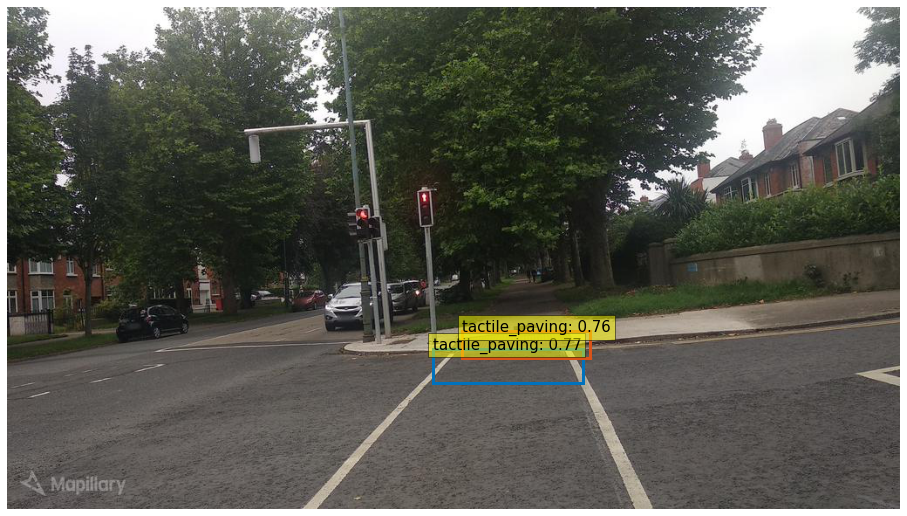

In [48]:
visualize_example()

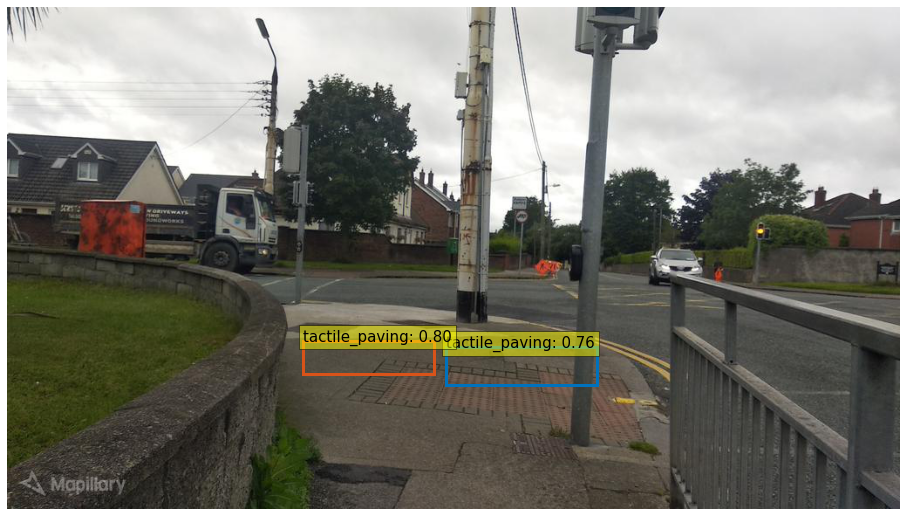

In [40]:
visualize_example(test_mode=False)